In [141]:
using Revise
using LinearAlgebra
using HierarchicalDA
using Distributions
using Statistics
using PDMats
using ProgressMeter
using KernelDensity
using QuadGK
using ApproxFun
using BenchmarkTools
using StaticArrays
using SpecialFunctions
using StatsFuns
using ForwardDiff
using Roots

In [2]:
using CairoMakie
using LaTeXStrings

In [3]:
Nx = 1
Ny = 1

1

In [4]:
πZ = MvNormal(zeros(Nx), PDiagMat(ones(Nx)))
πϵ = MvNormal(zeros(Nx), 0.01*PDiagMat(ones(Nx)))

DiagNormal(
dim: 1
μ: [0.0]
Σ: [0.01;;]
)


In [5]:
H = Diagonal(ones(Nx))

1×1 Diagonal{Float64, Vector{Float64}}:
 1.0

In [209]:
θgrid = collect(0.0:0.1:10.0)[2:end]
xgrid = collect(-3.0:0.1:3.0);

In [210]:
integrand_incomplete_extended_γ(α, κ, p, q, t) = t^(α-1)*exp(-t^κ/p - q/t)

integrand_incomplete_extended_γ (generic function with 1 method)

In [211]:
unnorm_pdf!(out, α::Float64, κ::Float64, p::Float64, q::Float64, t) = out .= t^(α-1)*exp(-t^κ/p - q/t)

unnorm_pdf! (generic function with 2 methods)

In [212]:
# Routine to compute the un-normalized probability density function
function unnorm_pdf(α::Float64, κ::Float64, p::Float64, q::Float64, t)
    out = zeros(eltype(t),1)
    unnorm_pdf!(out, α, κ, p, q, t)
    return out
end

unnorm_pdf (generic function with 2 methods)

In [213]:
# Routine to compute the normalizing constant of the probability density function
function Z!(out, α::Float64, κ::Float64, p::Float64, q::Float64) 
    quadgk!((b,a)->unnorm_pdf!(b,α, κ, p, q, a),out, 0.0, Inf)
    nothing
end

# Routine to compute the normalizing constant of the probability density function
function Z(α::Float64, κ::Float64, p::Float64, q::Float64)
    out = zeros(eltype(t),1)
    Z!(out, α, κ, p, q)
    return out
end

Z (generic function with 2 methods)

In [214]:
struct ExtendedGamma
    α::Float64
    κ::Float64
    p::Float64
    q::MVector{1, Float64}
    # Normalizing constant
    Z::MVector{1, Float64}
    cache::MVector{1, Float64}
end

function ExtendedGamma(α::Float64, κ::Float64, p::Float64, q::Float64)
    cache = MVector{1, Float64}(0.0)
    # Compute normalizing constant
    Z!(cache,α, κ, p, q)
    ZΓ = copy(cache)
    return ExtendedGamma(α, κ, p, MVector{1, Float64}(q), ZΓ, cache)
end


ExtendedGamma

In [254]:
unnorm_pdf!(out, Γ::ExtendedGamma, t::Real) = unnorm_pdf!(out, Γ.α, Γ.κ, Γ.p, Γ.q[1], t)

function unnorm_pdf(Γ::ExtendedGamma, t::Real)
    unnorm_pdf!(Γ.cache, Γ, t)
    return Γ.cache
end
   
function pdf!(out, Γ::ExtendedGamma, t::Real) 
    unnorm_pdf!(out, Γ, t)
    out ./= Γ.Z[1]
    nothing
end

function pdf(Γ::ExtendedGamma, t::Real)
    pdf!(Γ.cache, Γ, t)
    return Γ.cache
end

Z!(out, Γ::ExtendedGamma) = Z!(out, Γ.α, Γ.κ, Γ.p, Γ.q[1]) 

function Z(Γ::ExtendedGamma)
    Z!(Γ.cache, Γ)
    return Γ.cache
end

update_Z!(Γ::ExtendedGamma) = Z!(Γ.Z, Γ)


function cdf!(out, Γ::ExtendedGamma, x) 
    quadgk!((b,a)-> unnorm_pdf!(b, Γ, a),out, 0.0, x)[1]
    out ./= Γ.Z[1]
    nothing
end

function cdf(Γ::ExtendedGamma, x) 
    cdf!(Γ.cache, Γ, x)
    return Γ.cache
end

# Complementary of the CDF to 1
function ccdf!(out, Γ::ExtendedGamma, x) 
    quadgk!((b,a)-> unnorm_pdf!(b, Γ, a),out, x, Inf)[1]
    out ./= Γ.Z[1]
    nothing
end

# Complementary of the CDF to 1
function ccdf(Γ::ExtendedGamma, x) 
    ccdf!(Γ.cache, Γ, x)
    return Γ.cache
end

ccdf (generic function with 1 method)

In [255]:
# function generalized_gamma!(du, u, p, t)
#    du =  
# end

In [256]:
# Distributions.quantile(ηθ, 0.6)

In [257]:
# @time find_zero(x->cdf(Γstruct, x)[1] -0.1, [0, 100])

In [ ]:
f = Fun

In [318]:
Fun(x->cdf(Γstruct, x)[1], 0.0, Inf)

LoadError: MethodError: no method matching Fun(::var"#181#182", ::Float64, ::Float64)

[0mClosest candidates are:
[0m  Fun(::Any, [91m::Domain[39m, ::Any)
[0m[90m   @[39m [35mApproxFunBase[39m [90m~/.julia/packages/ApproxFunBase/clvO0/src/[39m[90m[4mconstructors.jl:86[24m[39m
[0m  Fun(::Function, [91m::Bernstein[39m)
[0m[90m   @[39m [36mApproxFunOrthogonalPolynomials[39m [90m~/.julia/packages/ApproxFunOrthogonalPolynomials/dqKLE/src/Spaces/[39m[90m[4mCurveSpace.jl:100[24m[39m
[0m  Fun(::Function)
[0m[90m   @[39m [35mApproxFunBase[39m [90m~/.julia/packages/ApproxFunBase/clvO0/src/[39m[90m[4mconstructors.jl:267[24m[39m
[0m  ...


In [258]:
cdf(Γstruct, 2.254659961024359)

1-element MVector{1, Float64} with indices SOneTo(1):
 0.9999570274134555

In [260]:
# power parameters
r_range = [ 1.0, .5, -.5, -1.0 ]; 
# shape parameters 
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ]; 
# rate parameters 
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ]; 

In [329]:
idx = 2
r = r_range[idx]
ϑ = ϑ_range[idx]
β = β_range[idx]

3.0918

In [330]:
α = r*β - 0.5
κ = r
p = ϑ^r
q = rand(Normal())^2

1.3881106496826853e-5

In [331]:
ηθ = Gamma(r*β, β)

Gamma{Float64}(α=1.5459, θ=3.0918)

In [332]:
function Sθ(Γ::ExtendedGamma, θ)
    cdf!(Γ.cache, Γ, θ)
    Distributions.quantile(ηθ, abs(Γ.cache[1]))
#     return gammainvcdf(1.0, 1.0, abs(Γ.cache[1]))
end

Sθ (generic function with 1 method)

In [333]:
Γstruct = ExtendedGamma(α, κ, p, q)

ExtendedGamma(1.0459, 0.5, 0.07702142559054591, [1.3881106496826853e-5], [0.00972262700206378], [0.00972262700206378])

In [334]:
θplot = collect(0.0:0.1:3)[2:end];

In [367]:
Fun(x->x, Interval(0,+Inf))

┌ Warning: Maximum number of coefficients 1048577 reached in constructing Fun.
└ @ ApproxFunBase ~/.julia/packages/ApproxFunBase/clvO0/src/constructors.jl:134


Fun(Chebyshev(【0.0,∞❫), [4.19378e6, 8.38757e6, 8.38756e6, 8.38756e6, 8.38755e6, 8.38755e6, 8.38755e6, 8.38754e6, 8.38754e6, 8.38753e6  …  39.9927, 35.9934, 31.9942, 27.9949, 23.9956, 19.9963, 15.9971, 11.9978, 7.99854, 3.99927])

In [369]:
@time chebΓ = Fun(x->pdf(Γstruct, x)[1], Interval(0,+Inf))
intchebΓ = cumsum(chebΓ)

  0.061564 seconds (140.16 k allocations: 10.332 MiB, 95.15% compilation time)


Fun(Chebyshev(【0.0,∞❫) ⊕ log((1+𝑪(【0.0,∞❫, x))^0 * (1-𝑪(【0.0,∞❫, x))^1) * Chebyshev(【0.0,∞❫), [0.89934, -3.47889e-9, 0.192727, 0.0, -0.169616, 0.0, 0.138514, 0.0, -0.106525, 0.0  …  0.0, 9.49009e-18, 0.0, 6.43179e-18, 0.0, 4.35185e-18, 0.0, 2.19311e-18, 0.0, 1.09122e-18])

In [379]:
intchebΓ()

Inf

In [372]:
x-> x- intchebΓ(x)/chebΓ(x)

#221 (generic function with 1 method)

In [365]:
pdf(Γstruct, 1.0)

1-element MVector{1, Float64} with indices SOneTo(1):
 0.00023636939342736772

In [356]:
@time

  0.001892 seconds (232 allocations: 3.151 MiB)


Fun(Chebyshev(【0.0,∞❫) ⊕ log((1+𝑪(【0.0,∞❫, x))^0 * (1-𝑪(【0.0,∞❫, x))^1) * Chebyshev(【0.0,∞❫), [0.89934, -3.47889e-9, 0.192727, 0.0, -0.169616, 0.0, 0.138514, 0.0, -0.106525, 0.0  …  0.0, 9.49009e-18, 0.0, 6.43179e-18, 0.0, 4.35185e-18, 0.0, 2.19311e-18, 0.0, 1.09122e-18])

In [360]:
D = Derivative()

ConcreteDerivative : ApproxFunBase.UnsetSpace() → ApproxFunBase.UnsetSpace()

In [361]:
D*chebπθ

Fun(Ultraspherical(1,【0.0,∞❫), [-12.7858, 23.8864, -32.1351, 37.1363, -39.1752, 38.9182, -37.1055, 34.3626, -31.1396, 27.7291  …  -1.15869e-9, 1.01312e-9, -8.68918e-10, 7.25493e-10, -5.8093e-10, 4.35323e-10, -2.90348e-10, 1.54758e-10, -5.48232e-11, 9.15212e-12])

In [358]:
intchebπθ(1.0)

0.999960506718259

In [359]:
cdf(Γstruct, 1.0)

1-element MVector{1, Float64} with indices SOneTo(1):
 0.9999605067174571

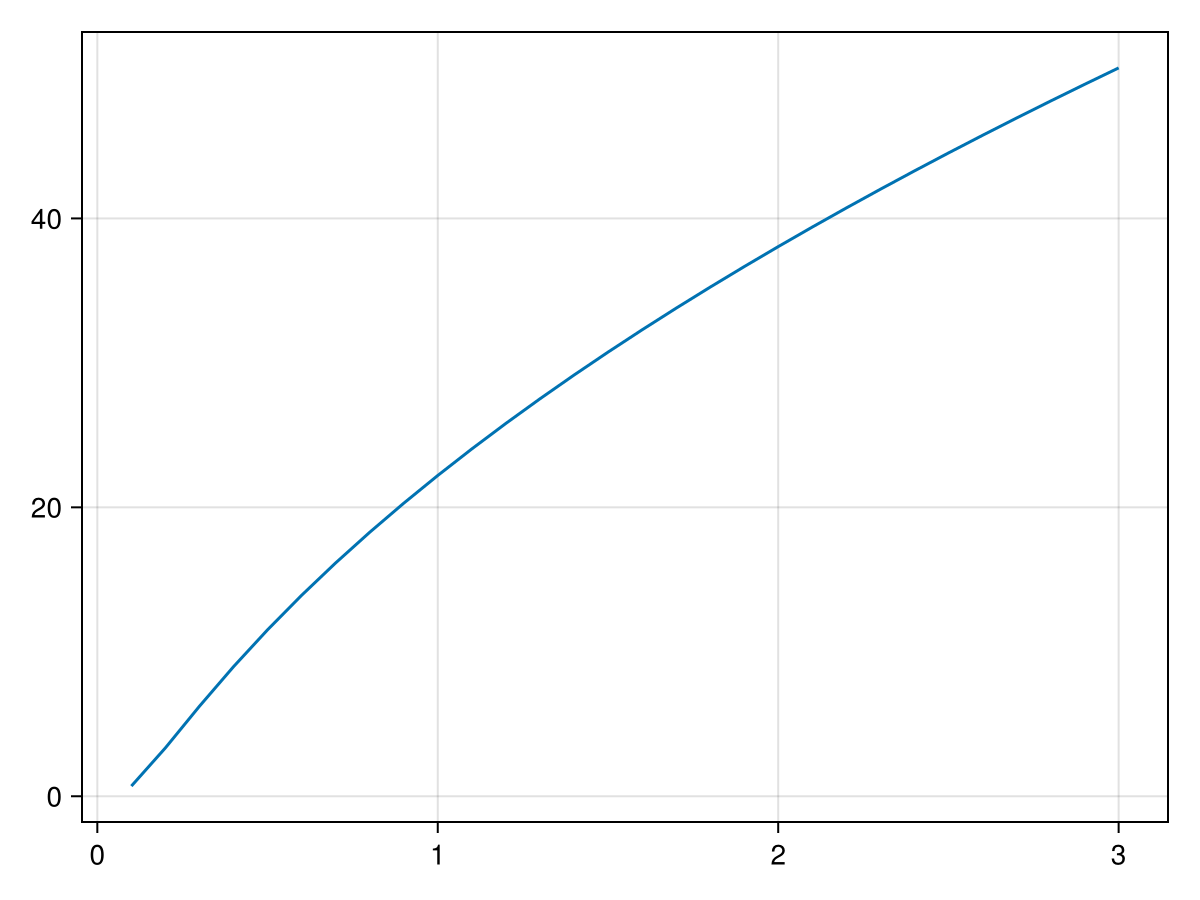

In [309]:
fig = Figure()

ax = Axis(fig[1,1])

lines!(ax, θplot, θ -> Sθ(Γstruct, θ)[1])
    
fig

In [ ]:
∫che/last(cf)

In [322]:
?ApproxFun.cumsum

```
cumsum(A; dims::Integer)
```

Cumulative sum along the dimension `dims`. See also [`cumsum!`](@ref) to use a preallocated output array, both for performance and to control the precision of the output (e.g. to avoid overflow).

# Examples

```jldoctest
julia> a = [1 2 3; 4 5 6]
2×3 Matrix{Int64}:
 1  2  3
 4  5  6

julia> cumsum(a, dims=1)
2×3 Matrix{Int64}:
 1  2  3
 5  7  9

julia> cumsum(a, dims=2)
2×3 Matrix{Int64}:
 1  3   6
 4  9  15
```

!!! note
    The return array's `eltype` is `Int` for signed integers of less than system word size  and `UInt` for unsigned integers of less than system word size. To preserve `eltype` of arrays with small signed or unsigned integer `accumulate(+, A)` should be used.

    ```jldoctest
    julia> cumsum(Int8[100, 28])
    2-element Vector{Int64}:
     100
     128

    julia> accumulate(+,Int8[100, 28])
    2-element Vector{Int8}:
      100
     -128
    ```

    In the former case, the integers are widened to system word size and therefore the result is `Int64[100, 128]`. In the latter case, no such widening happens and integer overflow results in `Int8[100, -128]`.


---

```
cumsum(itr)
```

Cumulative sum of an iterator.

See also [`accumulate`](@ref) to apply functions other than `+`.

!!! compat "Julia 1.5"
    `cumsum` on a non-array iterator requires at least Julia 1.5.


# Examples

```jldoctest
julia> cumsum(1:3)
3-element Vector{Int64}:
 1
 3
 6

julia> cumsum((true, false, true, false, true))
(1, 1, 2, 2, 3)

julia> cumsum(fill(1, 2) for i in 1:3)
3-element Vector{Vector{Int64}}:
 [1, 1]
 [2, 2]
 [3, 3]
```


In [310]:
πθ(θ) = θ^(α - 1)*exp(-β*θ - γ/(1 + θ)) /(1 + θ)^0.5

πθ (generic function with 1 method)

In [311]:
πθ(θ) = θ^(α - 1)*exp(-β*θ - γ/(1 + θ)) /(1 + θ)^0.5

πθ (generic function with 1 method)

In [31]:
chebπθ.(θgrid)

2001-element Vector{Float64}:
 -1.3877787807814457e-17
  0.0036237554951048575
  0.007138044098523133
  0.010543865210303382
  0.013842320966191972
  0.01703460683417426
  0.020122002774324174
  0.023105864934255357
  0.025987617853469546
  0.028768747150909248
  0.031450792671026684
  0.03403534206468277
  0.03652402478217457
  ⋮
  3.251280555658341e-17
  2.991447148307348e-17
  2.94616150614284e-17
  2.8079121238053247e-17
  2.7341774524638306e-17
  2.843323942183256e-17
  2.422210034186928e-17
  2.6074002165403292e-17
  2.3484402425148213e-17
  2.4126865543929616e-17
  2.3014545751889085e-17
  2.4662591362949787e-17

In [314]:
@time intchebπθ = integrate(chebπθ)

LoadError: UndefVarError: `chebπθ` not defined

In [53]:
@time quadgk(chebπθ, 0.0, 0.01)

  0.000037 seconds (9 allocations: 288 bytes)


(1.8210387344370225e-5, 4.0657581468206416e-20)

In [54]:
@time intchebπθ(0.01)

  0.000008 seconds (1 allocation: 16 bytes)


-0.05603673903089899

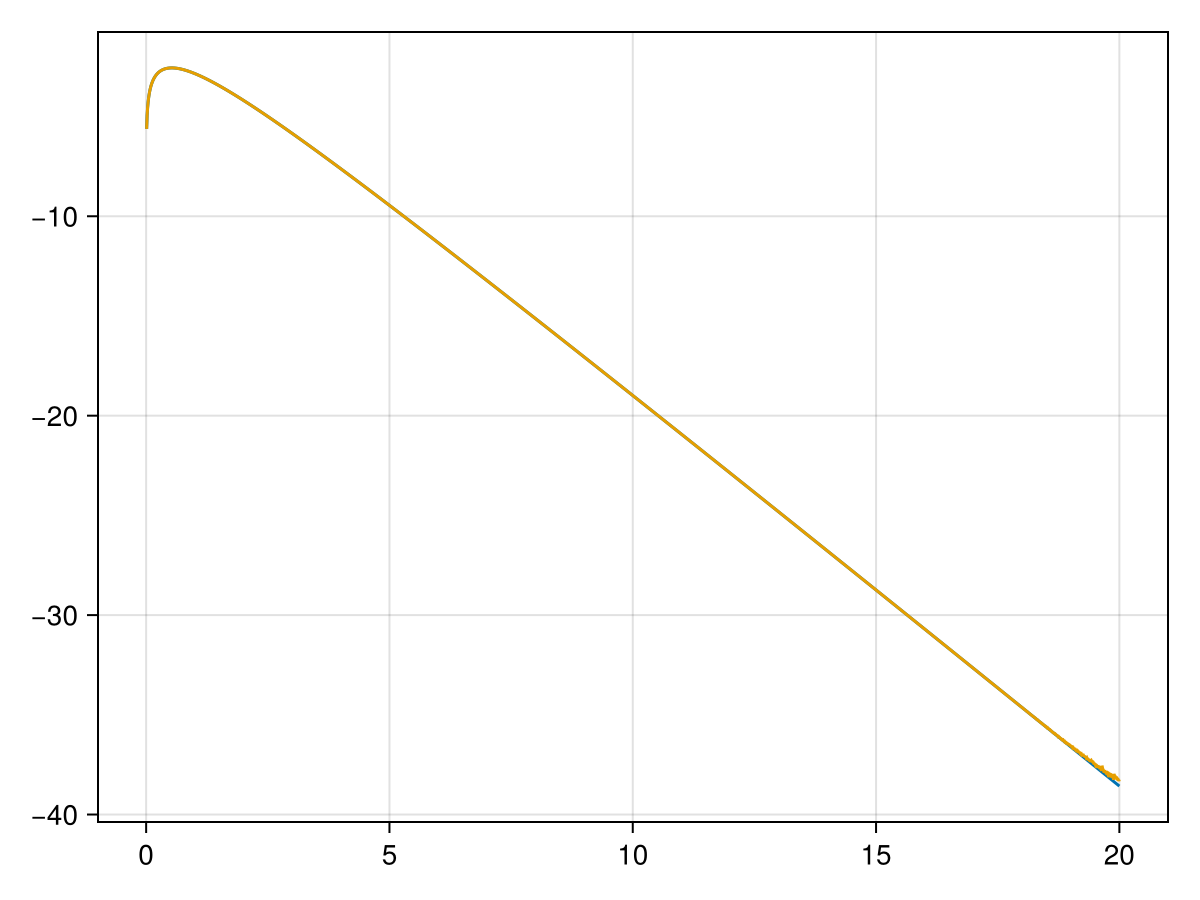

In [33]:
fig = Figure()

ax = Axis(fig[1,1])

lines!(ax, θgrid[2:end], log ∘ πθ)
lines!(ax, θgrid[2:end], log ∘ chebπθ)

    
fig

In [340]:
Ne = 10000

10000

In [341]:
# Working with the multi-variate version fixes the ambiguity of providing the standard deviation in 1D 
# and the covariance in multi-dimensions.
# Build joint distribution πθXY = πθ πX|θ πY|X
function πθXY(θ, x, y)
    if typeof(θ)<:Real && typeof(x)<:Real && typeof(y) <: Real
        return pdf(πmultiθ, [θ])*pdf(MvNormal(zeros(Nx), PDiagMat(inv.([θ]))), [x])*pdf(πϵ, [y] - H*[x])
    else
        return pdf(πmultiθ, θ)*pdf(MvNormal(zeros(Nx), PDiagMat(inv.(θ))), x)*pdf(πϵ, y - H*x)
    end
end

πθXY (generic function with 1 method)

In [342]:
πXY(x, y) = quadgk(θ -> πθXY(θ, x, y), 0, Inf)[1]

πXY (generic function with 1 method)

In [343]:
πθY(θ, y) = quadgk(x -> πθXY(θ, x, y), -Inf, Inf)[1]

πθY (generic function with 1 method)

In [344]:
πθgivenXY(θ, x, y) = πθXY(θ, x, y)/πXY(x, y)

πθgivenXY (generic function with 1 method)

In [345]:
πθgivenX(θ, x) = quadgk(y->πθXY(θ, x, y), -Inf, Inf)[1]/quadgk(y->πXY(x, y), -Inf, Inf)[1]

πθgivenX (generic function with 1 method)

In [346]:
πXgivenθY(θ, x, y) = πθXY(θ, x, y)/πθY(θ, y)

πXgivenθY (generic function with 1 method)

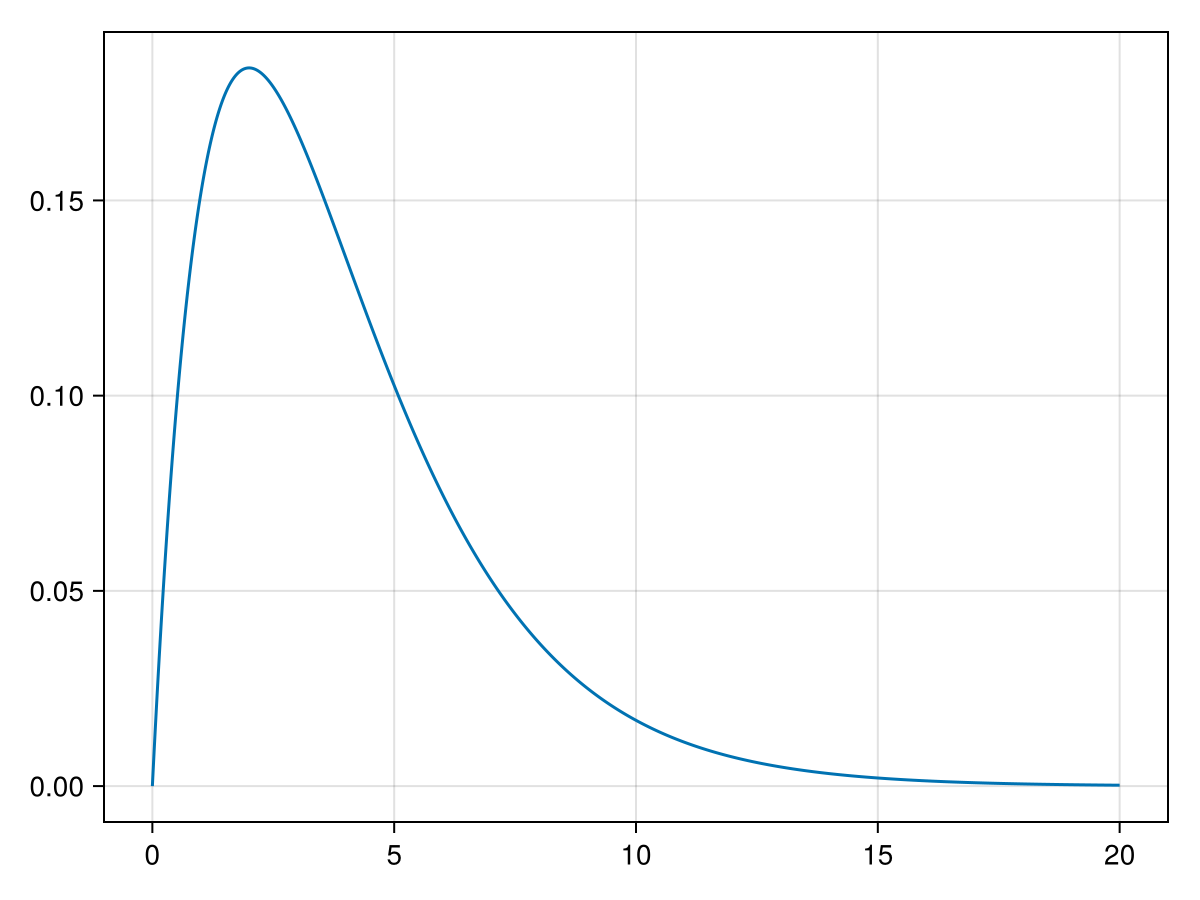

In [347]:
fig = Figure()

ax = Axis(fig[1,1])

lines!(ax, θgrid, pdf.(πθ, θgrid))
    
fig

In [348]:
function TX(θ::Matrix{Float64}, X::Matrix{Float64}, Y::Matrix{Float64}, H, ystar)
    Nθ, Neθ = size(θ)
    Nx, NeX = size(X)
    Ny, NeY = size(Y)
    @assert Neθ == NeX && NeX == NeY
    Ne = Neθ
    Xa = zero(X)
    for i = 1:Ne
        Dθi = PDiagMat(θ[:,i])
        bi = (H*Dθi\H + cov(πϵ))\(Y[:,i] - ystar)
        Xa[:,i] = X[:,i] - Dθi\(H'*bi)
    end
    return Xa
end

TX (generic function with 1 method)

In [349]:
function Tθ(θ::Matrix{Float64}, X::Matrix{Float64}, Xa::Matrix{Float64})
    Nθ, Neθ = size(θ)
    Nx, NeX = size(X)
    @assert Neθ == NeX
    Ne = Neθ
    θa = zero(X)
    for i = 1:Ne
        for j=1:Nx
            θa[j,i] = exp(log(β + 0.5*X[j,i]^2) - log((β + 0.5*Xa[j,i]^2)) + log(θ[j,i]))
        end
    end
    return θa
end

Tθ (generic function with 1 method)

In [350]:
# Generate ground truth
θstar = rand(πmultiθ)
xstar = rand(πZ) ./ sqrt.(θstar)
ϵstar = rand(πϵ)
ystar = H*xstar + ϵstar

1-element Vector{Float64}:
 -0.9379254315504845

In [351]:
Niter = 10

# Sample from πθ
θ = rand(πmultiθ, Ne)
θ0 = copy(θ)

# Sample from πX|θ = N(0, D_{θ}^{-1})
X = zeros(Nx, Ne)
for i=1:Ne
    X[:,i] = rand(πZ)./sqrt.(θ[:,i])
end
X0 = copy(X)

# Sample from πY|X
Y = zero(X)
for i=1:Ne
   Y[:,i] = H*X[:,i] + rand(πϵ)
end
Y0 = copy(Y)

Xa = zero(X)
θa = zero(θ)

@showprogress for n=1:Niter
    Y = H*X + rand(πϵ, Ne)
    Xa .= TX(θ, X, Y, H, ystar)
    θa .= Tθ(θ, X, Xa)
    copy!(X, Xa)
    copy!(θ, θa)
end

In [352]:
palette = Makie.wong_colors()

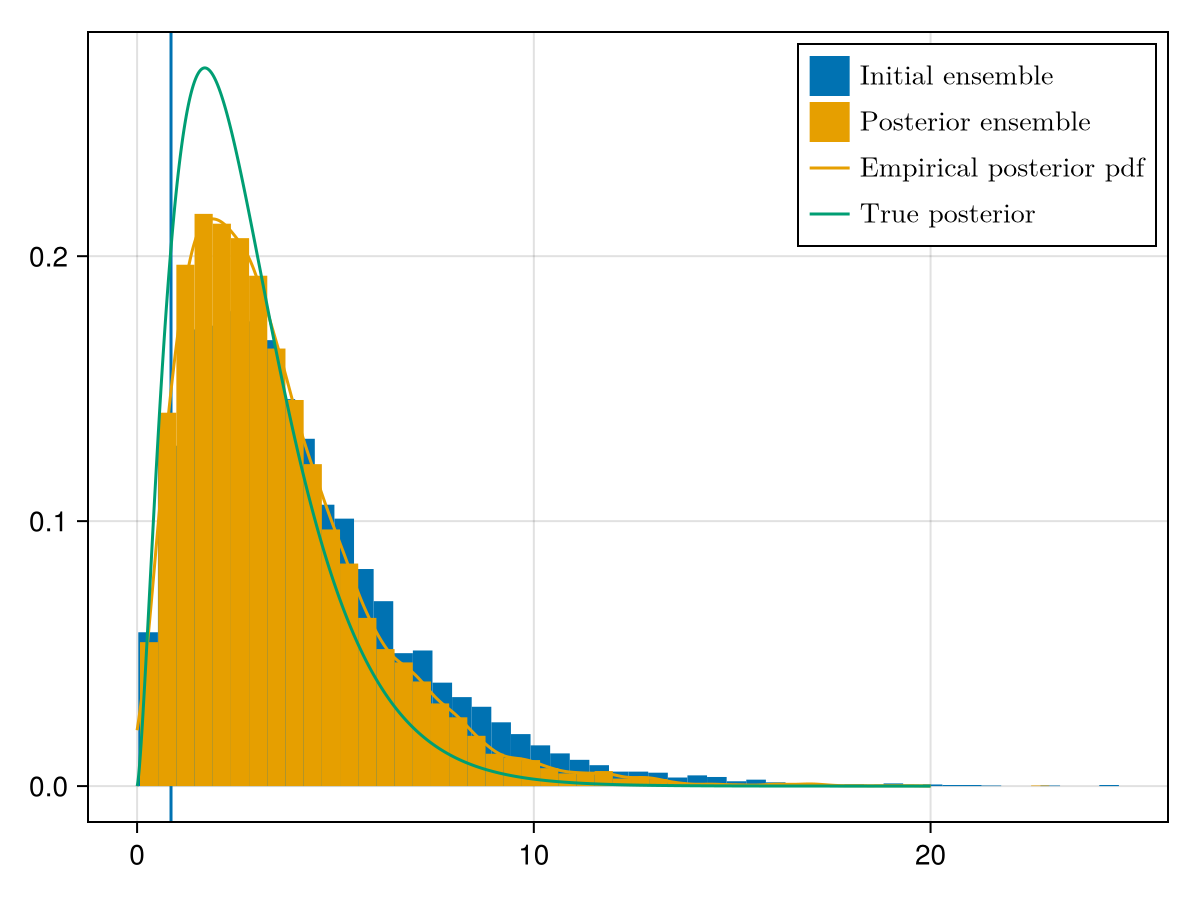

In [353]:
fig = Figure()

ax = Axis(fig[1,1])

for i=1:Nx
    kθi = KernelDensity.kde(θ[i,:])
    vlines!(ax, θstar[i])
    hist!(ax, θ0[1,:], normalization = :pdf, bins =50, label = L"\text{Initial ensemble}", color = palette[1])
    hist!(ax, θ[1,:], normalization = :pdf, bins =50, label = L"\text{Posterior ensemble}", color = palette[2])
    lines!(ax, θgrid, pdf(kθi, θgrid), label = L"\text{Empirical posterior pdf}", color = palette[2])

    lines!(ax, θgrid, πθgivenXY.(θgrid, xstar[1], ystar[1]), label = L"\text{True posterior}", color = palette[3])
end

axislegend()
fig

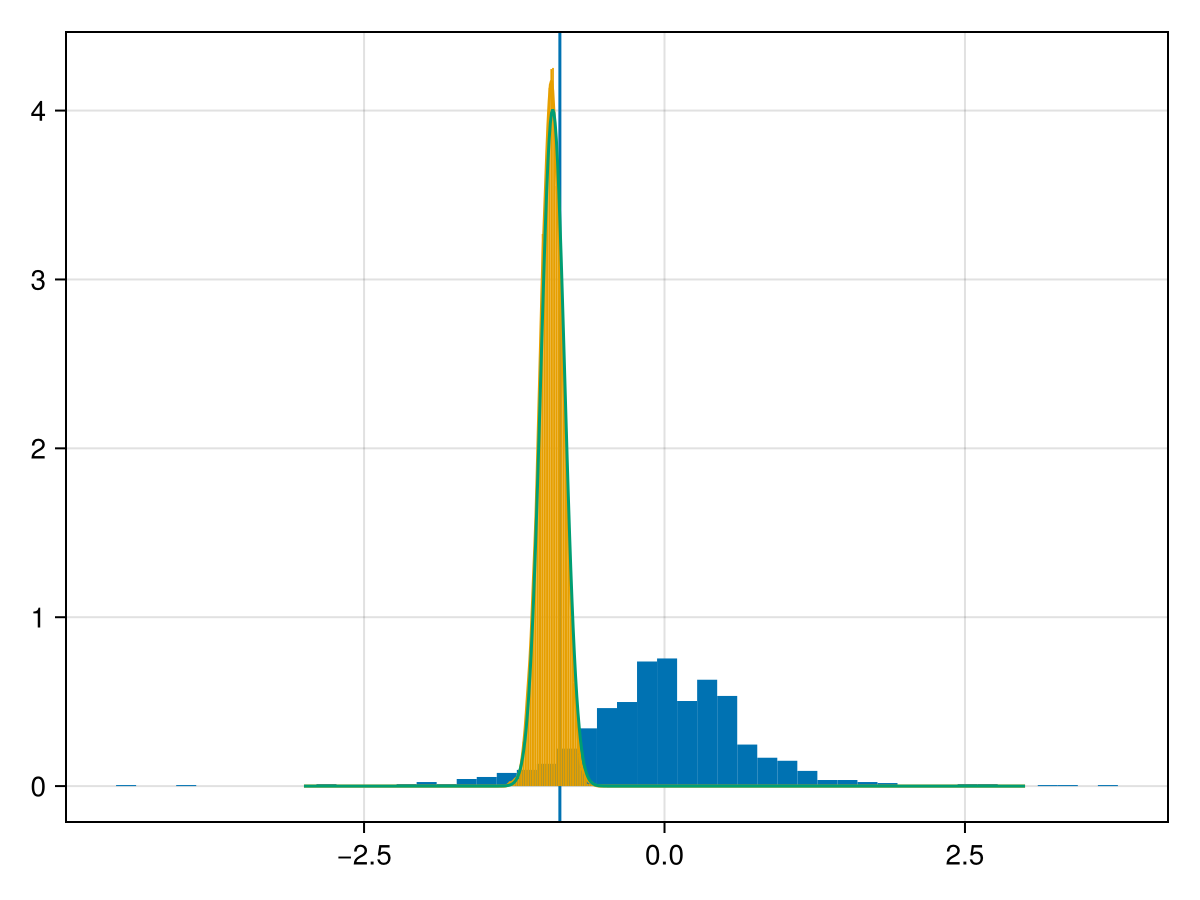

In [360]:
fig = Figure()

ax = Axis(fig[1,1])

for i=1:Nx
    kxi = KernelDensity.kde(X[i,:])
    vlines!(ax, xstar[i])
    hist!(ax, X0[1,1:1000], normalization = :pdf, bins =50, label = L"\text{Initial ensemble}", color = palette[1])
    hist!(ax, X[1,:], normalization = :pdf, bins =50, label = L"\text{Posterior ensemble}", color = palette[2])
    lines!(ax, xgrid, pdf(kxi, xgrid), label = L"\text{Empirical posterior pdf}", color = palette[2])

    lines!(ax, xgrid, πXgivenθY.(θstar[1], xgrid, ystar[1]), label = L"\text{True posterior}", color = palette[3])
end
fig

In [358]:
minimum(X0[1,1:1000])

-4.56330186455876